In [16]:
# !git clone https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025
!git clone -b ENSAI_students https://github.com/Anonymous-GT11/SAFRAN_ENSAI_2025


Cloning into 'SAFRAN_ENSAI_2025'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 78 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 1.10 MiB | 12.90 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [3]:
# Verify that we have sucessfully clone the repo and go the place where the repo is stored
%cd /content/SAFRAN_ENSAI_2025
!ls

/content/SAFRAN_ENSAI_2025
Cie_0_Engine0.csv	performancemodel_ENSAI.zip
performancemodel_ENSAI	README.md


In [4]:
# install the package performance_model
%cd /content/SAFRAN_ENSAI_2025/performancemodel_ENSAI/
!pip install .

/content/SAFRAN_ENSAI_2025/performancemodel_ENSAI
Processing /content/SAFRAN_ENSAI_2025/performancemodel_ENSAI
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for performancemodel: filename=performancemodel-0.0.1-py3-none-any.whl size=30485 sha256=6d927b587e5bce3a09b0ddf3b9a31c5909c25595eccf6adc5eec978a822ae3bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-mfd7rmz8/wheels/b4/6e/66/25433221b4a4d2ead6faf834b0fa81054260e4a8996e629ab9
Successfully built performancemodel


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm

from performancemodel.base_system import h_SCSF
from performancemodel.scenarios import simulate_degradation_trajectory, generate_multiple_trajectories
from performancemodel.plot import plot_trajectory


# Challenge SCSF

In this notebok we show how to create data for a challenge with the simulator SCSF implemented in this library and propose a solution to the challenge. This notebook will be divided into three parts :

1) Data Generation
2) Solver Construction
3) Tests and Results

## Data Generation

In this chapter we show how to construct degradation trajectories and how to get measurements from the simulator along the trajectories.

### Trajectory generation

The SCSF simulator has only two degrading modules, the compressor and the turbine. For each of this module, we have an health indicator that can vary between 1.95 and 1.02. We will now show how to construct degradation trajectories for each of this indicator.

In [6]:
traj = simulate_degradation_trajectory()
traj_waterwash =simulate_degradation_trajectory(waterwash="frequent")
traj_fast = simulate_degradation_trajectory(speed="fast")

In [7]:
plot_trajectory(traj)
plot_trajectory(traj_waterwash)
plot_trajectory(traj_fast)

In [8]:
S =  ['P3', 'P4', 'P5', 'T3', 'T4', 'T5', 'W2R', 'W5', 'W8R', 'Wf', 'F']
# Note that in this simulator there is no noise added, in the challenge noise should be added
test_measurements = h_SCSF(traj, S=S, as_dict=True)

In [9]:
data_measurements = pd.DataFrame(list(test_measurements))

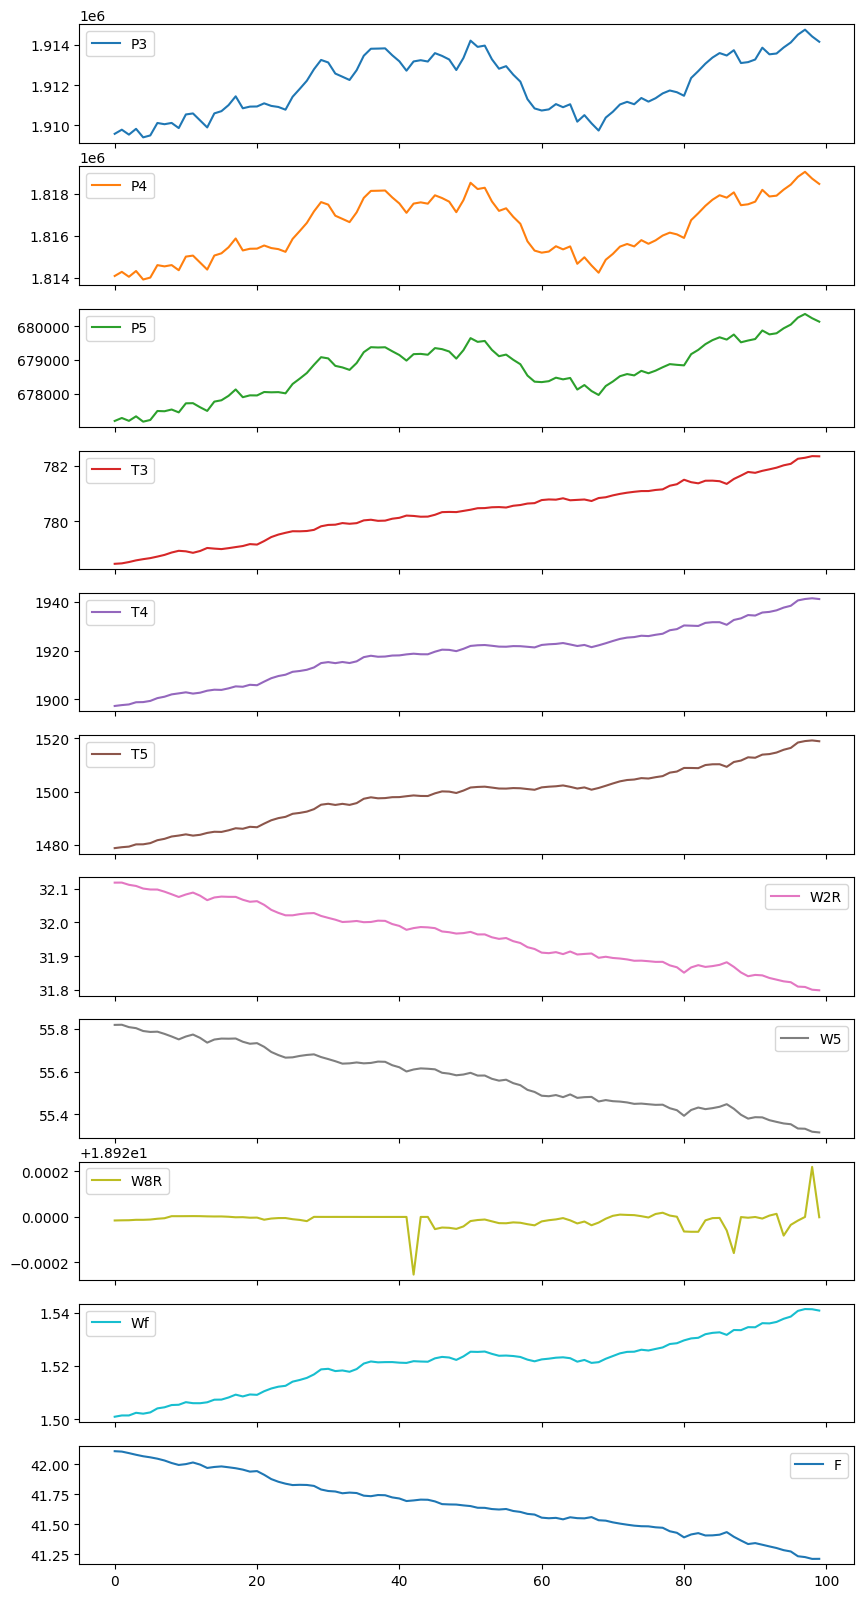

In [10]:
data_measurements.plot(subplots=True, figsize=(10, 20));

To create multiple trajetories in order to create a dataset for a challenge we implemented a simple version of a multiple trajectory generation function. This function can be found in src/scenarios.py and can be modified in order to create more adequate trajectories if needed.
By default it creates 100 trajectories.

In [11]:
multiple_traj = generate_multiple_trajectories(n_trajectories=100)

In [12]:
# multiple_traj is a list of dictionary
print(multiple_traj[0].keys())

dict_keys(['speed', 'waterwash', 'size', 'trajectory'])


## Solver Construction

The challenge aims to estimate at each point of the trajectory the health indicators from the measurements. One can imagine many ways to do this task. We implement in this notebook a simple NLGPA (Non Linear Gas Path Analysis) with direct optimisation (least square) for demonstration purposes. The model that aims to estimate can be a trainable model or any other methods that comes to mind. If one want to use a trainable model, then a train set have to be generated in a previous step thanks to the simulator.

In [13]:

def inverse_nlgpa(y_measured, func_simu, x0=[1.0, 1.0], **kwargs):
    """
    y_measured: mesures (liste ou array)
    func_simu: simulateur f(x)
    x0: point initial pour l’optimisation
    kwargs: paramètres à passer à func_simu (ex: S=..., autre_param=...)
    """
    def loss_fn(x):
        y_pred = func_simu([x], S=S, **kwargs)
        return np.sum((np.array(y_pred) - np.array(y_measured))**2)

    result = minimize(loss_fn, x0, bounds=[(0.95, 1.02), (0.95, 1.02)], method="L-BFGS-B", options={"maxiter":100 , "disp": False})
    return result.x

def estimate_traj(measured_series, **kwargs):
    x0 = [1, 1]
    estimated_traj = []

    for i in range(len(measured_series)):
        estimated_traj_temp = inverse_nlgpa(measured_series[i], h_SCSF, x0=x0, **kwargs)
        x0 = estimated_traj_temp
        estimated_traj.append(estimated_traj_temp)

    return estimated_traj



## Tests and Results

In this chapter we test our method on a random trajectory computed thanks to the simulate_degradation_trajectory function. Since our method takes some time to compute estimation, we restrain ourself to a trajectory of size 10.

Then we compare our estimation with the true trajectory. We also compare observed measurements with the measurements we would obtain from the simulator with estimated performance indicators as inputs.

In [14]:
# Generate a test trajectory
traj_test = simulate_degradation_trajectory(speed='normal', waterwash='rare', size=10, seed=0)

# Simulated measurements
measured_series_test = list(h_SCSF(traj_test, S=S))



In [15]:
# This step might take some times because it is not optimized, so don't hesitate to change "max iter" option in inverse_nlgpa to run the code
# just to run it for debug
estimated_traj_test = estimate_traj(measured_series_test)


/tmp/ipython-input-3879753057.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.

/tmp/ipython-input-3879753057.py:12: DeprecationWarning:

scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.



KeyboardInterrupt: 

In [ ]:
true_traj = np.array(traj_test)
est_traj = np.array(estimated_traj_test)

fig = go.Figure()

fig.add_trace(go.Scatter(y=true_traj[:, 0], mode="lines", line=dict(color="blue"), name="True trajectory compressor"))
fig.add_trace(go.Scatter(y=est_traj[:, 0], mode="lines", line=dict(color="blue", dash="dash"), name="Estimated trajectory compressor health"))

fig.add_trace(go.Scatter(y=true_traj[:, 1], mode="lines", line=dict(color="red"), name="True trajectory turbine"))
fig.add_trace(go.Scatter(y=est_traj[:, 1], mode="lines", line=dict(color="red", dash="dash"), name="Estimated trajectory turbine health"))

fig.show()




In [ ]:
measured_series = pd.DataFrame(list(h_SCSF(traj_test, S=S, as_dict=True)))
measure_pred_series = pd.DataFrame(list(h_SCSF(estimated_traj_test, S=S, as_dict=True)))

palette = px.colors.qualitative.Prism
palette = palette + px.colors.qualitative.Prism

fig = make_subplots(rows=5, cols=3, subplot_titles=measured_series.columns)

i=0
j=0

show_legend=True
for col_ in measured_series.columns:

    fig.add_trace(go.Scatter(y=measured_series[col_], mode="lines", line=dict(color=palette[i]), name="True measurements", legendgroup="True measurements", showlegend=show_legend), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(y=measure_pred_series[col_], mode="lines", line=dict(color=palette[i], dash="dash"), name="Estimated measurements", legendgroup="Estimated measurements", showlegend=show_legend), row=i+1, col=j+1)

    j+=1
    if j > 2:
        j=0
        i+=1

    if show_legend:
        show_legend = False


fig.update_layout(height=200*5)
fig.show()



Next we also compute numerical score of our methodology. We use two different scoring :
1) RMSE error along the trajectory for each indicator
2) Slope error for each indicator

In [ ]:
def trajectory_error(traj, est):

    traj = np.array(traj)
    est = np.array(est)
    out_0 = np.sqrt(np.sum((traj[:,0] - est[:,0])**2))
    out_1 = np.sqrt(np.sum((traj[:,1] - est[:,1])**2))

    out = [out_0, out_1]

    return out

def slope_error(traj, est): # We should certainly add a window size, because slope for 1 step time is not ok
    traj = np.array(traj)
    est = np.array(est)

    def total_slope(coord):
        return coord[-1] - coord[0]

    # Pente totale sur X
    slope_x_real = total_slope(traj[:, 0])
    slope_x_est = total_slope(est[:, 0])
    error_slope_x = slope_x_est - slope_x_real

    # Pente totale sur Y
    slope_y_real = total_slope(traj[:, 1])
    slope_y_est = total_slope(est[:, 1])
    error_slope_y = slope_y_est - slope_y_real

    return [error_slope_x, error_slope_y]


In [ ]:
traj_error = trajectory_error(true_traj, est_traj)
slope_error = slope_error(true_traj, est_traj)
print(traj_error, slope_error)